In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np
from typing import Union
import math

sys.path.append('..')
from lib.model_utils import ModelUtil, export_rules_to_csv
utils = ModelUtil(data_name = 'german', model_name = 'random forest')

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [15]:
mat = utils.get_cover_matrix(utils.X, fuzzy = True)

In [31]:
mat0 = utils.get_cover_matrix(utils.X, fuzzy = False)

In [69]:
def run_loci(data: np.ndarray, alpha: float = 0.5, k: int = 3):
    """Run the LOCI algorithm on the specified dataset.
    Runs the LOCI algorithm for the specified datset with the specified
    parameters, returns a LOCI object, from which outlier indices can
    be accessed via the indice property.
    Parameters
    ----------
    data: np.ndarray
        Shape - [number of datapoints, number of dimensions]
    alpha: float, optional
        Default is 0.5 as per the paper. See the paper for full details.
    k: int, optional
        Default is 3 as per the paper. See the paper for full details.
    """
    loci_i = LOCIMatrix(data, alpha, k)
    loci_i.run()
    return loci_i



class LOCIMatrix():
    """
    data: np.ndarray
    alpha: float, optional
    k: int, optional
    See the loci function for more details on the parameters.
    Attributes
    ----------
    _data: np.ndarray
    _alpha: float
    _k: int
    max_dist: float
    n_points: int
    indice: np.ndarray
    _dist_matrix: np.ndarray
        The distance matrix, has shape [n_data_points, n_data_points]
    """

    def __init__(self, data: np.ndarray, alpha: float = 0.5, k: int = 3):
        self.data = data
        self.alpha = alpha
        self.k = k

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.indice = None
        self.dist_matrix = pairwise_distances(X = self.data, metric='euclidean')
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        r_max = self.sorted_dist[:, sqrt_n].max() / self.alpha
        r_min = self.sorted_dist[:, 10].min()
        self.rs = []
        self.scores = [[] for _ in range(self.n_points)]
        print('r range: %.3f - %.3f, alpha: %.3f' % (r_min, r_max, self.alpha))

        n_steps = 250
        for i in range(n_steps):
            r = i / n_steps * (r_max - r_min) + r_min
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    if sigma_mdef > 0:
                        score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        step = (r_max - r_min) / n_steps
        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        self.indice = np.array([int((self.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(self.n_points)])
        self.min_indice = np.array([np.argmin(self.scores[i]) for i in range(self.n_points)])
        self.max_indice = np.array([np.argmax(self.scores[i]) for i in range(self.n_points)])
        self.scores = np.array(self.scores)
        self.outlier_score = np.array([self.scores[i, self.indice[i]] for i in range(self.n_points)])
        return True

    def label_propagation(self, x, label, thres = 0.10):
        conf = {}
        visit = {}
        conf[x] = 1
        Q = [x]
        head = 0
        while head < len(Q):
            x = Q[head]
            head += 1
            if x in visit:
                continue
            visit[x] = 1
            
            if label == 0:
                new_indice = self.min_indice[x]
            else:
                new_indice = self.max_indice[x]
            self.indice[x] = self.indice[x] * conf[x] + new_indice * (1 - conf[x])
            for i, j in enumerate(self.sorted_neighbors[x]):
                sim = (1 - self.sorted_dist[x, i]) * conf[x]
                if sim < thres:
                    break
                conf[j] = conf.get(j, 0) + sim
                Q.append(j)

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [32]:
res0 = run_loci(mat0)

r range: 0.250 - 1.016, alpha: 0.850


In [19]:
res = run_loci(mat)

r range: 0.189 - 1.010, alpha: 0.850


In [132]:
res_e = run_loci(mat, alpha = 0.9)

r range: 1.414 - 16.600, alpha: 0.900


In [27]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(res.dist_matrix)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


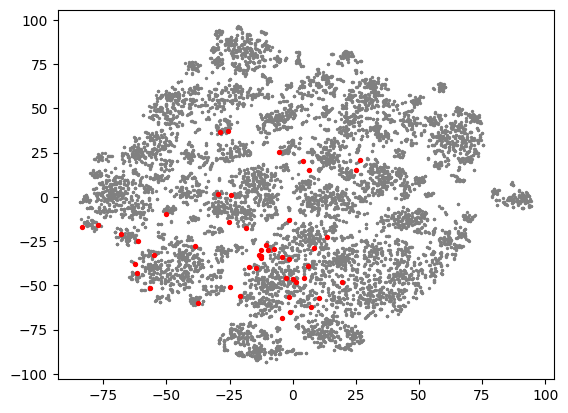

In [136]:
anomaly = res_e.outlier_score.argsort()[-50:][::-1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 8, color='red')
plt.show()

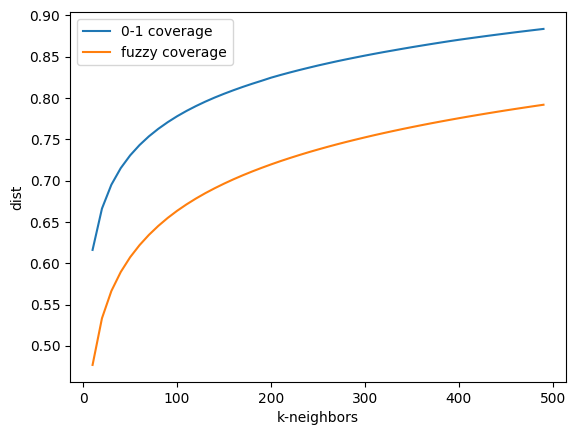

In [35]:
fig, ax = plt.subplots()
xs = [i for i in range(10, 500, 10)]
ax.plot(xs, res0.sorted_dist[:, xs].mean(axis = 0), label='0-1 coverage')
ax.plot(xs, res.sorted_dist[:, xs].mean(axis = 0), label='fuzzy coverage')
ax.set_xlabel('k-neighbors')
ax.set_ylabel('dist')
ax.legend()
plt.show()

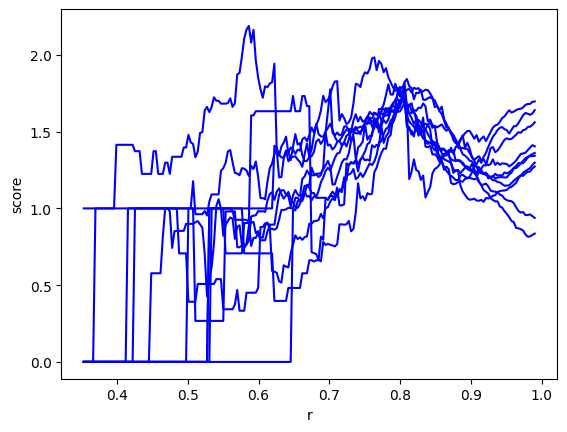

In [140]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-10:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

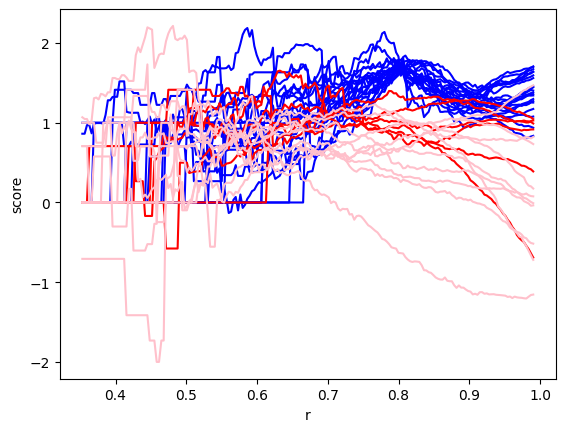

In [135]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = [1,2,3,4,5,6,7,8,9,50]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][50:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][50:-5]])
    s_mdefs = np.array([max(y[2], 0.01) for y in res.result[x]['records'][50:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

In [88]:
all_labels = {7305: 1, 8624: 0, 1884: 1, 468: 1, 6290: 0, 8055: 0, 2280: 1, 3400: 1, 4466: 0, 4650: 0, 6028: 1, 4459: 1, 1411: 1, 665: 0, 868: 1, 8911: 1, 3848: 0, 9283: 0, 5218: 0, 3035: 0, 1010: 1, 8934: 1, 6483: 1, 2807: 1, 5767: 1, 1763: 1, 4479: 1, 679: 1, 873: 1, 6641: 1, 178: 0, 2278: 1, 7567: 0, 287: 1, 7527: 1, 6569: 1, 3487: 1, 2363: 1, 1750: 0, 2300: 1, 6277: 0, 8240: 1, 7499: 1, 525: 0, 4785: 0, 9324: 0, 3337: 1, 3617: 1, 5003: 1, 2089: 1, 3204: 1, 991: 1, 2167: 1, 3488: 1, 1507: 1, 1840: 1, 4932: 1, 254: 1, 9096: 1, 5974: 0, 7529: 1, 2764: 1, 9134: 1, 2112: 0, 7845: 0, 8073: 1, 4657: 0, 3270: 1, 5502: 1, 616: 1, 6787: 0, 6801: 1, 3486: 1, 405: 1, 3485: 1, 8092: 1, 1393: 0, 668: 1, 8389: 0, 2277: 1, 8629: 0, 1520: 1, 4104: 1, 712: 0, 6952: 1, 1330: 1, 8415: 1, 6471: 1, 690: 1, 5575: 1, 5590: 0, 5252: 0, 2079: 1, 1940: 0, 3891: 1, 2916: 0, 1939: 1, 6839: 0, 4384: 1, 3628: 1, 2664: 1, 8645: 1, 7572: 1, 736: 0, 2228: 1, 4759: 1, 729: 0, 4980: 1, 2009: 1, 2099: 0, 4995: 0, 7810: 1, 7571: 1, 5459: 1, 2817: 1, 4812: 1, 4983: 0, 6289: 0, 8022: 0, 4647: 1, 3618: 1, 9452: 1, 4978: 1, 4350: 1, 2706: 1, 758: 1, 2500: 0, 1017: 0, 7915: 0, 5237: 1, 1963: 1, 7556: 0, 3451: 1, 4977: 1, 7456: 1, 424: 1, 4867: 1, 2279: 1, 4234: 0, 3313: 1, 1703: 1, 9289: 0, 827: 0, 8258: 1}


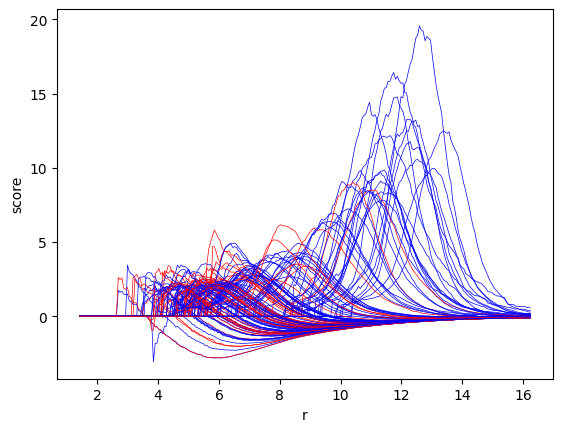

In [141]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
tp = [i for i in all_labels if all_labels[i] == 1]
lines = []

xs = res_e.rs[:-5]
for x in fp:
    lines.append((res_e.scores[x, :-5], 'r', x))
for x in tp:
    lines.append((res_e.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

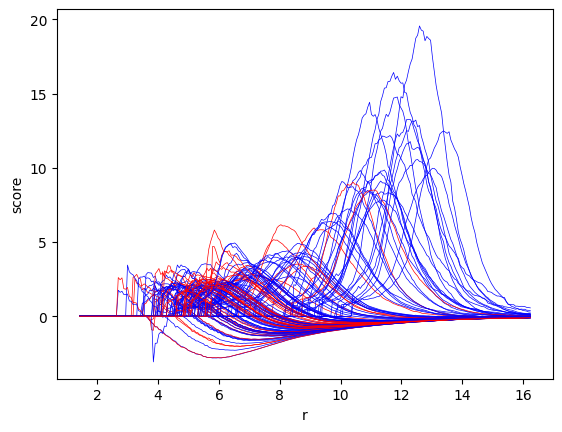

In [138]:
fig, ax = plt.subplots()
fp = [i for i in all_labels if all_labels[i] == 0]
tp = [i for i in all_labels if all_labels[i] == 1]
lines = []

xs = res_e.rs[:-5]
for x in fp:
    lines.append((res_e.scores[x, :-5], 'r', x))
for x in tp:
    lines.append((res_e.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [142]:
max_count = 0
for k in range(50, len(xs)):
    count = 0
    for i in np.argsort([x[0][k] for x in lines])[-50:][::-1]:
        count += all_labels[lines[i][2]]
    if count > max_count:
        max_count = count
        print(xs[k], max_count)

4.451435149515193 33
4.512179581258034 35
4.572924013000876 37
8.642800939771288 39
8.946523098485498 40
9.189500825456866 41
9.61471184765676 42
13.745333206170013 43
16.175110475883688 44


In [116]:
res_e.rs[135]

16.78605073482887

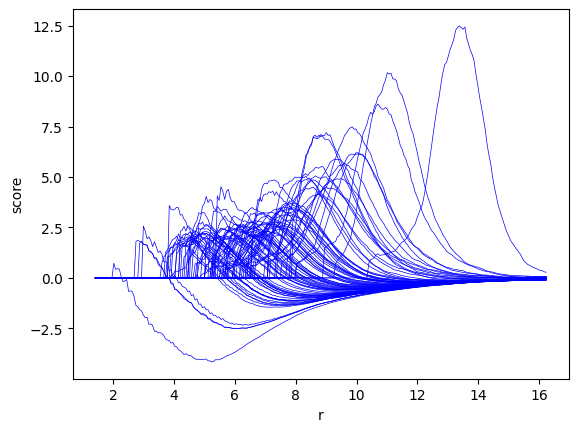

In [139]:
fig, ax = plt.subplots()
lines = []

xs = res_e.rs[:-5]
for x in range(1, 9000, 100):
    lines.append((res_e.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=0.5)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

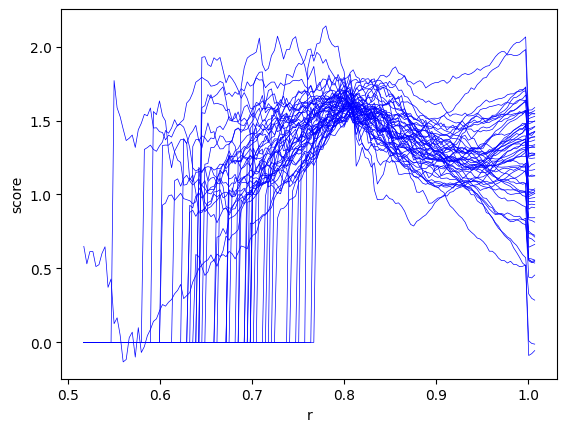

In [62]:

res.outlier_score = res.scores[:, 188]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [146]:
export_rules_to_csv('loci_euclidean_r16_alpha_0.9', utils, res_e.scores[:, 240].argsort()[-50:][::-1])

In [148]:
o_idxes = [668, 8019, 6515, 2009, 8020, 2819, 7878, 4381, 8235, 6455]
print(res.outlier_score[o_idxes].mean(), res0.outlier_score[o_idxes].mean())

-0.038075857587926795 1.4361684578022136
110.45090312884813 13.6


In [169]:
utils.feature_range

{'status': [1, 5],
 'duration': [4, 73],
 'amount': [250, 18425],
 'savings': [1, 6],
 'employment_duration': [1, 6],
 'installment_rate': [1, 5],
 'personal_status_sex': [0, 2],
 'present_residence': [1, 5],
 'age': [19, 76],
 'credit_history': [0, 5],
 'purpose': [0, 11],
 'other_debtors': [0, 3],
 'property': [0, 4],
 'other_installment_plans': [0, 3],
 'housing': [0, 3],
 'job': [0, 4],
 'people_liable': [0, 2],
 'telephone': [0, 2],
 'foreign_worker': [0, 2],
 'number_credits': [0, 4]}

In [168]:
utils.interpret_path(utils.paths[o_idxes[0]])

([('status', 'is', '... >= 200 DM (salary)'),
  ('credit_history', 'is not', 'existing credits paid back duly till now'),
  ('amount', 'in', '1024 to 1357'),
  ('other_debtors', 'is', 'none'),
  ('other_installment_plans', 'is not', 'bank'),
  ('number_credits', 'is', '1')],
 'accept')

In [178]:
print(mat[o_idxes[0]][:50])
print(mat0[o_idxes[0]][:50])
rule = mat[o_idxes[0]]
rule = rule[np.flatnonzero((rule > 0) * (rule < 0.3))]
print(rule)

[0.         0.         0.48261443 0.         0.         0.
 0.         0.         0.         0.2279977  0.         0.
 0.         0.         0.         0.         0.         0.26850491
 0.35125534 0.         0.         0.         0.34604727 0.48377177
 0.         0.         0.         0.         0.48623853 0.35665138
 0.56536697 0.         0.         0.98738532 0.         0.
 0.         0.         0.51490826 0.         0.         0.
 0.         0.         0.50460405 0.         1.         0.
 0.94036697 0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
[0.2279977  0.26850491 0.28784404 0.28875851 0.14293257 0.24304324
 0.21121615 0.14756196 0.1805464  0.17475966 0.14177522 0.22973373
 0.10184669 0.24420058 0.20068807 0.17431193 0.18577982 0.1128415
 0.24082569 0.15277003 0.25       0.26908358 0.13946052 0.11862825
 0.21989626 0.28702249 0.23783517 0.22133028 0.21931759 0.2

In [177]:
np.flatnonzero((mat0[o_idxes[0]] > 0))

array([ 46,  60, 124, 180, 194, 230, 263, 270, 333, 434, 488, 495, 500,
       523, 628, 735, 842])

In [152]:
print('hole', res.sorted_dist[o_idxes, 100].mean(), res0.sorted_dist[o_idxes, 100].mean())
print('all', res.sorted_dist[:, 100].mean(), res0.sorted_dist[:, 100].mean())

hole 0.6265893837741175 0.8357690817471889
all 0.6634305079897133 0.7778646738533405


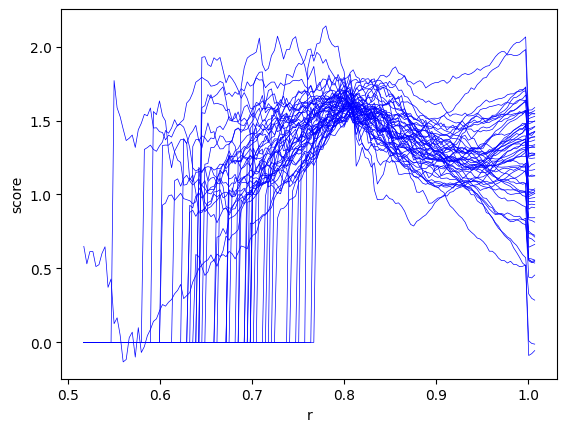

In [ ]:

res.outlier_score = res.scores[:, 188]
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-50:]
for x in tp:
    ranks = []
    ax.plot(res.rs[100:], res.scores[x, 100:], linewidth=0.5, color='b')
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

In [154]:
res.sorted_dist[:, 20].mean() / res.sorted_dist[:, 100].mean()

0.8039245235268431

In [155]:
res0.sorted_dist[:, 20].mean() / res0.sorted_dist[:, 100].mean()

0.8563419496867082

In [185]:
export_rules_to_csv('euclidean_r12_top10', utils, res_e.scores[:, 76].argsort()[-10:][::-1])

In [186]:
res_e.scores[res_e.scores[:, 175].argsort()[-10:][::-1], 175]

array([31.43627015, 28.56642752, 27.85932388, 25.74745237, 25.74320701,
       21.92742162, 21.51329301, 21.074741  , 19.55989744, 18.99753554])

In [184]:
np.flatnonzero(np.array(res_e.rs) > 12)[0]

175

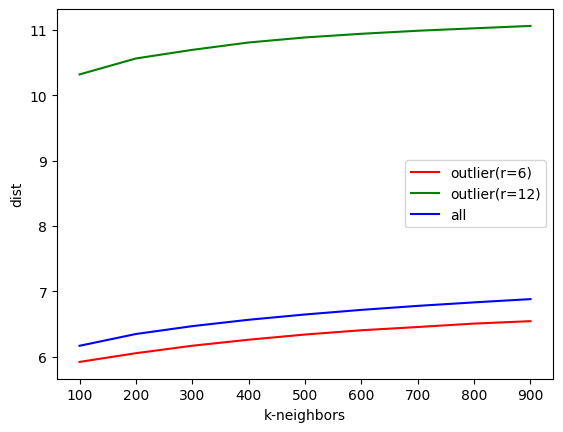

In [193]:
anomaly_12 = res_e.scores[:, 175].argsort()[-10:][::-1]
anomaly_6 = res_e.scores[:, 76].argsort()[-10:][::-1]
fig, ax = plt.subplots()
lines = []

xs = [k for k in range(100, 1000, 100)]

ax.plot(xs, [res_e.sorted_dist[anomaly_6, k].mean() for k in range(100, 1000, 100)], color='r', label="outlier(r=6)")
ax.plot(xs, [res_e.sorted_dist[anomaly_12, k].mean() for k in range(100, 1000, 100)], color='g', label="outlier(r=12)")
ax.plot(xs, [res_e.sorted_dist[:, k].mean() for k in range(100, 1000, 100)], color='b', label="all")
ax.set_xlabel('k-neighbors')
ax.set_ylabel('dist')
ax.legend()
plt.show()

In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import numpy as np
from typing import Union
import math

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from lib.model_reduction_variant import Extractor
from lib.anomaly_detection import LOCIMatrix
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.notebook_repr_html = False 
plt.rcParams['figure.dpi'] = 75 
sns.set_theme(style='darkgrid') 

In [4]:

from lib.model_utils import ModelUtil
model = ModelUtil(data_name = 'german_credit', model_name = 'RF')
paths = model.paths
mat = model.get_cover_matrix(model.X, fuzzy = True, byclass = False)
res = LOCIMatrix(mat, alpha = 0.8, metric = 'euclidean')
res.run()
res.select_indice(11.5)


Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308
r range: 1.414 - 18.675, alpha: 0.800


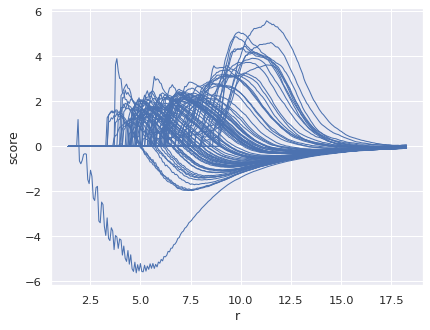

In [6]:
fig, ax = plt.subplots()
lines = []

xs = res.rs[:-5]
for x in range(2, 9000, 100):
    lines.append((res.scores[x, :-5], 'b', x))

import random
random.shuffle(lines)
for (ys, color, index) in lines:
    ax.plot(xs, ys, color=color, linewidth=1)
ax.set_xlabel('r')
ax.set_ylabel('score')
plt.show()

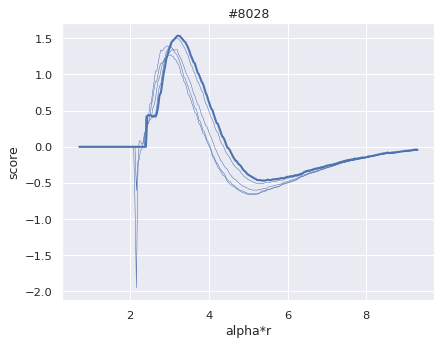

In [26]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 8028
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#8028')
plt.show()

In [22]:
idx = 8028
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

8028 IF housing is for free AND telephone is Yes AND status is not ... >= 200 DM (salary) AND other_installment_plans is none THEN reject
8551 IF other_installment_plans is none AND credit_history is not existing credits paid back duly till now AND status is not ... >= 200 DM (salary) AND telephone is Yes AND housing is for free THEN reject
7485 IF housing is for free AND savings is not >= 1000 DM AND property is not real estate AND telephone is Yes AND status is no checking account THEN accept
4205 IF status is not ... >= 200 DM (salary) AND housing is for free AND employment_duration is not unemployed AND personal_status_sex is married male AND telephone is Yes AND installment_rate is >= 35 THEN reject
5725 IF telephone is Yes AND duration <= 33 AND property is unknown / no property AND housing is for free AND status is not 0 to 200 DM and ... >= 200 DM (salary) THEN accept


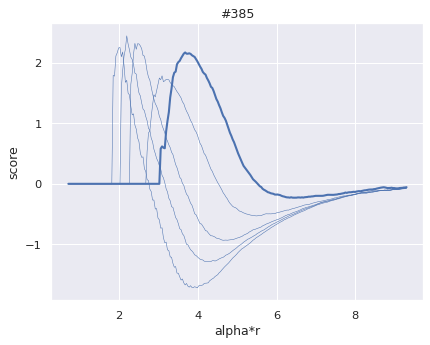

In [27]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 385
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#385')
plt.show()

In [21]:
idx = 385
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

385 IF number_credits is 2 to 3 AND housing is own AND amount <= 7766 AND credit_history is all credits at this bank paid back duly AND duration >= 11 AND purpose is not others AND property is not real estate AND telephone is No THEN accept
8876 IF housing is own AND property is not real estate AND purpose is not others and furniture/equipment AND number_credits is not 1 AND savings is not >= 1000 DM AND telephone is No AND credit_history is all credits at this bank paid back duly THEN accept
8877 IF housing is own AND property is not real estate AND purpose is furniture/equipment AND number_credits is not 1 AND savings is not >= 1000 DM AND telephone is No AND credit_history is all credits at this bank paid back duly THEN accept
9459 IF property is not real estate AND other_installment_plans is not bank AND housing is own AND credit_history is all credits at this bank paid back duly AND telephone is No AND amount >= 4049 THEN accept
8986 IF telephone is No AND housing is not rent AND 

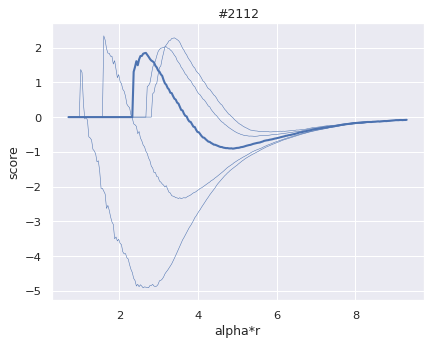

In [28]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 2112
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#2112')
plt.show()

In [20]:

idx = 2112
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

2112 IF status is ... >= 200 DM (salary) AND credit_history is not existing credits paid back duly till now AND telephone is No AND amount <= 3615 AND other_debtors is not none THEN accept
665 IF status is ... >= 200 DM (salary) AND credit_history is not existing credits paid back duly till now AND amount <= 3882 AND other_debtors is not none THEN accept
5218 IF status is ... >= 200 DM (salary) AND other_debtors is not none THEN accept
8389 IF duration <= 15 AND other_installment_plans is none AND purpose is not others AND credit_history is no credits taken/all credits paid back duly AND amount >= 804 AND other_debtors is co-applicant THEN accept
7089 IF savings is unknown/no savings account or < 100 DM AND telephone is No AND property is not building soc. savings agr./life insurance AND status is ... >= 200 DM (salary) AND people_liable is 3 or more AND housing is rent THEN accept


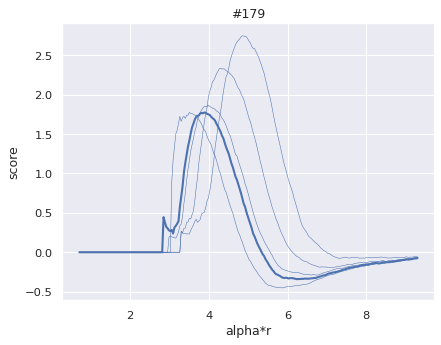

In [23]:
fig, ax = plt.subplots()
lines = []

xs = np.array(res.rs[:]) * 0.5
idx = 179
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    lines.append((res.scores[x, :], 'b', x, 2 if x == idx else 0.5))

import random
random.shuffle(lines)
for (ys, color, index, width) in lines:
    ax.plot(xs, ys, color=color, linewidth=width)
ax.set_xlabel('alpha*r')
ax.set_ylabel('score')
ax.set_title('#179')
plt.show()

In [16]:
def rule_to_text(rule):
    conds = rule[0]
    ret = rule[1]
    return 'IF ' + ' AND '.join(['%s %s %s' % (str(a), str(b), str(c)) for (a, b, c) in conds]) + ' THEN ' + ret

In [19]:

idx = 179
idxes = res.sorted_neighbors[idx, :5]
for x in idxes:
    print(x, rule_to_text(model.interpret_path(paths[x])))

179 IF savings is unknown/no savings account or < 100 DM AND property is real estate AND employment_duration is unemployed or < 1 yr AND housing is own AND age <= 32 THEN accept
180 IF savings is unknown/no savings account or < 100 DM AND property is real estate AND employment_duration is unemployed or < 1 yr AND housing is own AND age >= 32 THEN accept
5966 IF property is real estate AND savings is unknown/no savings account or < 100 DM AND purpose is not car (new) AND housing is own AND duration <= 11 AND employment_duration is not 4 to 7 yrs and >= 7 yrs THEN accept
5030 IF other_debtors is none AND savings is not 500 to 1000 DM and >= 1000 DM AND housing is own AND property is real estate AND amount >= 1082 AND age <= 25 THEN reject
4316 IF housing is own AND other_installment_plans is not bank AND job is not management/ self-employed/ highly qualified employee/ officer AND employment_duration is unemployed or < 1 yr AND credit_history is no credits taken/all credits paid back duly

In [35]:
paths[179]

{'range': {3: [-100000000000000.0, 2.9844443798065186],
  27: [0.9992890357971191, 100000000000000.0],
  4: [-100000000000000.0, 2.939416527748108],
  35: [0.9116452038288116, 100000000000000.0],
  8: [-100000000000000.0, 32.0]},
 'value': 0.0,
 'weight': 1,
 'tree_index': 3,
 'rule_index': 35,
 'name': 'r3_35',
 'confidence': 0.5,
 'sample': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [25]:
res.sorted_dist.mean()

8.348170821922853

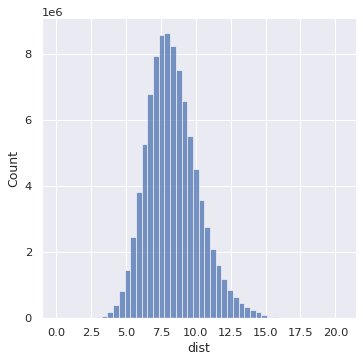

In [24]:
import seaborn as sns
import pandas as pd
dist_data = pd.DataFrame({ 'dist': res.sorted_dist[:, 1:].reshape(-1) })
sns.displot(data=dist_data, x="dist", bins=50, log_scale=(False, False))
plt.show()

In [29]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(res.dist_matrix)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


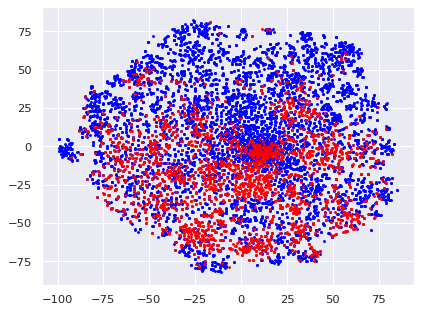

In [36]:
pos = [i for i in range(len(paths)) if paths[i]['output'] == 1]
neg = [i for i in range(len(paths)) if paths[i]['output'] == 0]
plt.scatter(x_tsne[pos, 0], x_tsne[pos, 1], s = 3, color='blue')
plt.scatter(x_tsne[neg, 0], x_tsne[neg, 1], s = 3, color='red')
plt.show()

In [37]:
paths[0]['output']

1

In [44]:
[p for p in paths if np.sum(p['sample']) == 0]

[]

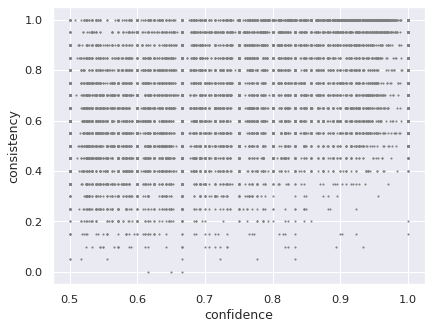

In [71]:
conf = [p['confidence'] for p in paths]
consistent = []
for i, p in enumerate(paths):
    count = 0
    for j in res.sorted_neighbors[i, 1: 21]:
        if paths[j]['output'] == paths[i]['output']:
            count += 1
    consistent.append(count / 20)
fig, ax = plt.subplots()    
plt.scatter(conf, consistent, s = 1, color='gray')
ax.set_xlabel('confidence')
ax.set_ylabel('consistency')
plt.show()

In [72]:
vec = np.array([[conf[i], consistent[i]] for i in range(len(consistent))]).astype('float')
counts = np.zeros((10, 10))
for i in range(10):
    x1 = (9 - i) * 0.1
    for j in range(10):
        x2 = j * 0.1
        counts[i, j] = np.sum((vec[:, 0] > x1) * (vec[:, 0] <= x1 + 0.1) * (vec[:, 1] > x2) * (vec[:, 1] <= x2 + 0.1))
print(counts)

[[  1.   4.   2.  30.  99. 264. 300. 209. 202. 713.]
 [  5.  10.  15.  51. 131. 264. 258. 228. 242. 420.]
 [  7.  18.  62. 122. 227. 324. 338. 239. 262. 337.]
 [  8.  41.  89. 217. 336. 330. 324. 271. 220. 202.]
 [ 14.  53. 127. 217. 357. 349. 315. 225. 158. 121.]
 [  2.   6.  13.  52.  55.  57.  42.  33.  27.  13.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]


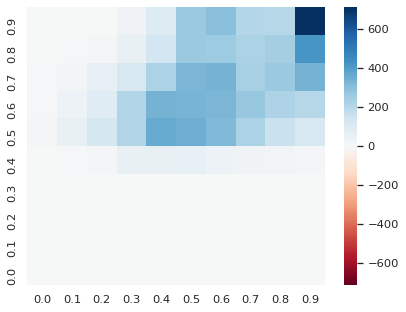

In [74]:
f, ax = plt.subplots()
ax = ax.invert_yaxis()
sns.heatmap(counts, cmap="RdBu", ax=ax, vmin=-counts.max(),
    xticklabels = [round(i * 0.1, 2) for i in range(10)],
    yticklabels = [round(0.9 - i * 0.1, 2) for i in range(10)]
    )
plt.show()